# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

# Part 1: Downloading and preparing the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [1]:
# Imports
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, InputLayer, Embedding
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text  # Registers the ops.

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils

In [2]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [3]:
# Load data from the database
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('restaurant',), ('reviewer',)]
[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [4]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)

print(f'The data set contains {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 5858 reviews, and 5123 reviewers


In [5]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)

print(f'The data set contains {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 67019 reviews, and 16941 reviewers


In [6]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))

restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['date'] = restaurant_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [7]:
# Split data according to the research paper, i.e. balanced new reviews after 2012-01-01
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_X_test = hotel_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
hotel_X_test_positive = hotel_X_test[hotel_X_test['flagged'] == 'Y']
hotel_X_test_negative = hotel_X_test[hotel_X_test['flagged'] == 'N']
hotel_X_test_balanced = pd.concat([hotel_X_test_positive, hotel_X_test_negative.sample(n=len(hotel_X_test_positive))], ignore_index=True)
hotel_X_test = hotel_X_test_balanced.sample(frac=1)
hotel_y_test = hotel_X_test_balanced['flagged'] == 'Y'
hotel_X_train_and_dev = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_X_train, hotel_X_dev, hotel_y_train, hotel_y_dev = train_test_split(hotel_X_train_and_dev, hotel_X_train_and_dev['flagged']=='Y')

restaurant_X_test = restaurant_reviews[restaurant_reviews['date'] >= datetime.datetime(2012, 1, 1)]
restaurant_X_test = restaurant_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
restaurant_X_test_positive = restaurant_X_test[restaurant_X_test['flagged'] == 'Y']
restaurant_X_test_negative = restaurant_X_test[restaurant_X_test['flagged'] == 'N']
restaurant_X_test_balanced = pd.concat([restaurant_X_test_positive, restaurant_X_test_negative.sample(n=len(restaurant_X_test_positive))], ignore_index=True)
restaurant_X_test = restaurant_X_test_balanced.sample(frac=1)
restaurant_y_test = restaurant_X_test_balanced['flagged'] == 'Y'
restaurant_X_train_and_dev = restaurant_reviews[restaurant_reviews['date'] < datetime.datetime(2012, 1, 1)]
restaurant_X_train, restaurant_X_dev, restaurant_y_train, restaurant_y_dev = train_test_split(restaurant_X_train_and_dev, restaurant_X_train_and_dev['flagged']=='Y')


# Part 2: Exploratory Data Analysis

In [8]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 4847 to 3947
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3402 non-null   datetime64[ns]
 1   reviewID       3402 non-null   object        
 2   reviewerID     3402 non-null   object        
 3   reviewContent  3402 non-null   object        
 4   rating         3402 non-null   int64         
 5   usefulCount    3402 non-null   int64         
 6   coolCount      3402 non-null   int64         
 7   funnyCount     3402 non-null   int64         
 8   flagged        3402 non-null   object        
 9   hotelID        3402 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 292.4+ KB


In [9]:
restaurant_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42086 entries, 16842 to 10580
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           42086 non-null  datetime64[ns]
 1   reviewID       42086 non-null  object        
 2   reviewerID     42086 non-null  object        
 3   reviewContent  42086 non-null  object        
 4   rating         42086 non-null  int64         
 5   usefulCount    42086 non-null  int64         
 6   coolCount      42086 non-null  int64         
 7   funnyCount     42086 non-null  int64         
 8   flagged        42086 non-null  object        
 9   restaurantID   42086 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.5+ MB


In [10]:
reviews = pd.concat([restaurant_X_train, hotel_X_train.rename(columns={'hotelID':'restaurantID'})], ignore_index=True)
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent']

5002     ***Longman & Eagle is a true gastropub--a casu...
10200    ***Alinea is truly a one-of-a-kind experience;...
34880    ***Graham Elliot serves up refined casual food...
43380    ***While the rooms are small, Hotel Felix is a...
Name: reviewContent, dtype: object

In [11]:
reviews.groupby('flagged').agg('sum')

,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,157884,43730,28650,24670
Y,21775,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,1433,1433,1433,1433,1433,1433,1433,1433,1433
2,2807,2807,2807,2807,2807,2807,2807,2807,2807
3,5905,5905,5905,5905,5905,5905,5905,5905,5905
4,15333,15333,15333,15333,15333,15333,15333,15333,15333
5,14358,14358,14358,14358,14358,14358,14358,14358,14358


(array([ 1433.,     0.,  2807.,     0.,     0.,  5905.,     0., 15333.,
            0., 14358.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

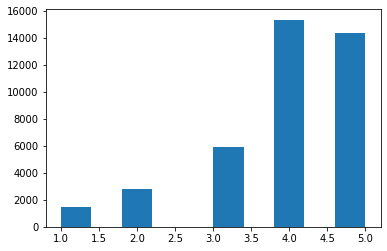

In [12]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,648,648,648,648,648,648,648,648,648
2,453,453,453,453,453,453,453,453,453
3,507,507,507,507,507,507,507,507,507
4,1520,1520,1520,1520,1520,1520,1520,1520,1520
5,2524,2524,2524,2524,2524,2524,2524,2524,2524


(array([ 648.,    0.,  453.,    0.,    0.,  507.,    0., 1520.,    0.,
        2524.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

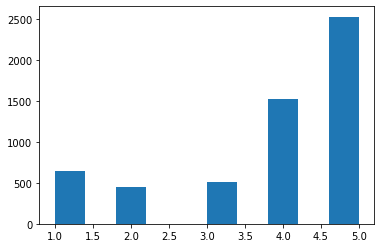

In [13]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

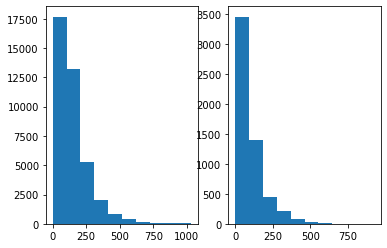

In [14]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

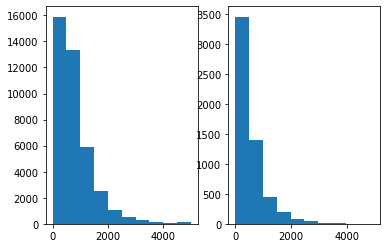

In [15]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

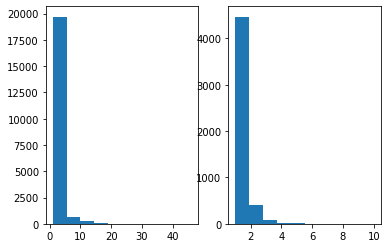

In [16]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


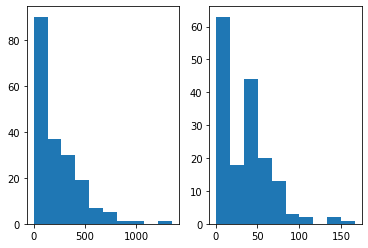

In [17]:
trueRestReviewCounts = trueReviews.groupby(['restaurantID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['restaurantID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


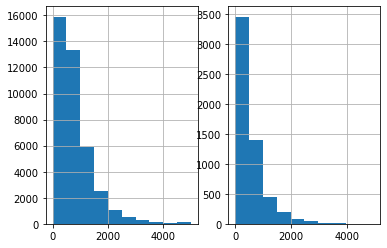

In [18]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


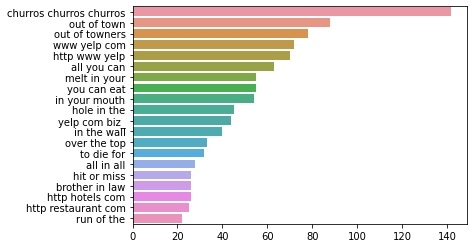

In [19]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

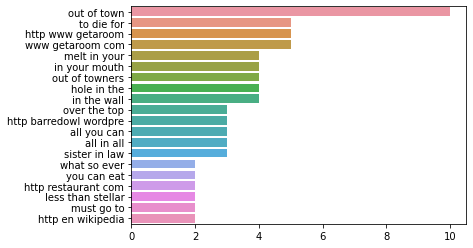

In [20]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

In [21]:
fake_df = restaurant_reviews[restaurant_reviews['flagged'] == 'Y']["reviewerID"].to_frame()
true_df = restaurant_reviews[restaurant_reviews['flagged'] == 'N']["reviewerID"].to_frame()
print("Fake Reviewers " + str(len(fake_df["reviewerID"].unique())))
print("True Reviewers " + str(len(true_df["reviewerID"].unique())))
print("True and Fake Reviewers " + str(len(list(set(fake_df["reviewerID"].unique()) & set(true_df["reviewerID"].unique())))))

Fake Reviewers 7118
True Reviewers 28049
True and Fake Reviewers 138


In [22]:
full_rest_df = pd.merge(restaurant_reviews, restaurant_reviewers, on="reviewerID")
fake_df = full_rest_df[full_rest_df['flagged'] == 'Y']["firstCount"]
true_df = full_rest_df[full_rest_df['flagged'] == 'N']["firstCount"]
print("Fake stats Counts " + str(fake_df.count()) + str(" Sum ") + str(fake_df.sum()))
print("True stats Counts " + str(true_df.count()) + str(" Sum ") + str(true_df.sum()))

Fake stats Counts 6206 Sum 1549
True stats Counts 20752 Sum 225700


# Part 3: Model Training

## Preparing for the word embeddings

In [23]:
# GloVe Embeddings
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')
    
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.300d.txt"

glove_dimension = 300
glove_embedding_map = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embedding_map[word] = coefs

print("Found %s word vectors." % len(glove_embedding_map))

def get_glove_embedding(word):
    return glove_embedding_map.get(word.strip(), None)


Already downloaded the embedding
Found 400000 word vectors.


In [24]:
# Pre-trained Elmo
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def get_elmo_embedding(words):
    return elmo.signatures['default'](tf.constant(words))['elmo']


2021-11-27 00:21:53.126992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1: GloVe Embedding + Plain LSTM

In [25]:
def build_model_1_hotel(num_epochs=2, sequence_length=50):
    
    # First layer, vectorizing the word input
    m1_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m1_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m1_hotel_voc = m1_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m1_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m1_hotel_voc)

    # Prepare embedding matrix
    m1_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m1_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m1_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m1_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m1_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m1_hotel_vectorizer(hotel_X_train['reviewContent']).numpy()
    hotel_X_dev_ready = m1_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m1_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_1_hotel')
    model.add(m1_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [26]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_1_hotel(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         5801400   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,894,905
Trainable params: 93,505
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
107/107 [==============================] - 11s 84ms/step - loss: 0.3922 - accuracy: 0.8721
Epoch 2/5
107/107 [======

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=200
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 200)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 400)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_6 (LSTM)               (None, 64)                93440     
                                                                 
 dense

107/107 [==============================] - 42s 367ms/step - loss: 0.4245 - accuracy: 0.8742
Epoch 2/15
107/107 [==============================] - 40s 374ms/step - loss: 0.3777 - accuracy: 0.8745
Epoch 3/15
107/107 [==============================] - 39s 368ms/step - loss: 0.3754 - accuracy: 0.8745
Epoch 4/15
107/107 [==============================] - 40s 371ms/step - loss: 0.3754 - accuracy: 0.8748
Epoch 5/15
107/107 [==============================] - 40s 375ms/step - loss: 0.3729 - accuracy: 0.8754
Epoch 6/15
107/107 [==============================] - 40s 370ms/step - loss: 0.3713 - accuracy: 0.8760
Epoch 7/15
107/107 [==============================] - 40s 375ms/step - loss: 0.3697 - accuracy: 0.8760
Epoch 8/15
107/107 [==============================] - 40s 370ms/step - loss: 0.3699 - accuracy: 0.8760
Epoch 9/15
107/107 [==============================] - 40s 376ms/step - loss: 0.3674 - accuracy: 0.8760
Epoch 10/15
107/107 [==============================] - 40s 372ms/step - loss: 0.3672

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

## Model 2 - Data Resampling + GloVe Embedding + LSTM

In [27]:
# Split the positive/negative samples for more balanced sampling
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

def build_model_2_hotel(num_epochs=2, sequence_length=50, resample_ratio=0.5):

    # First layer, vectorizing the word input
    m2_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m2_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m2_hotel_voc = m2_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m2_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m2_hotel_voc)

    # Prepare embedding matrix
    m2_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m2_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m2_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m2_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m2_hotel_embedding_matrix),
        trainable=False,
    )
    
    # Oversample some positive training samples
    num_negative_samples = len(hotel_X_train_negative)
    positive_ratio = resample_ratio
    hotel_positives = hotel_X_train_positive.sample(n=int(num_negative_samples * positive_ratio), replace=True).reset_index(drop=True)
    hotel_negatives = hotel_X_train_negative

    hotel_X_train_balanced = pd.concat([hotel_positives, hotel_negatives], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'
    
    # Vectorize the input
    hotel_X_train_ready = m2_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m2_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m2_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_2_hotel')
    model.add(m2_hotel_embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    

There are 427 positive examples
There are 2975 negative examples


In [28]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        for resample_ratio in [0.3, 0.4, 0.5, 0.6, 0.7]:
            print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}, ratio={resample_ratio}")
            build_model_2_hotel(num_epochs=num_epochs, sequence_length=sequence_length, resample_ratio=resample_ratio)

Start training with num_epochs=5, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_9 (LSTM)               (None, 128)               219648    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,021,177
Trainable params: 219,777
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
121/121 [==============================] - 17s 118ms/step - loss: 0.5396 - accuracy: 0.7680
Epoch 2/5
12

149/149 [==============================] - 18s 123ms/step - loss: 0.5571 - accuracy: 0.6985
Epoch 3/5
149/149 [==============================] - 17s 116ms/step - loss: 0.4436 - accuracy: 0.7628
Epoch 4/5
149/149 [==============================] - 19s 125ms/step - loss: 0.3469 - accuracy: 0.8292
Epoch 5/5
149/149 [==============================] - 18s 124ms/step - loss: 0.2919 - accuracy: 0.8603
              precision    recall  f1-score   support

       False       0.77      0.89      0.83       857
        True       0.33      0.16      0.21       277

    accuracy                           0.72      1134
   macro avg       0.55      0.53      0.52      1134
weighted avg       0.66      0.72      0.68      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.69      0.52      0.59       283
        True       0.38      0.54      0.44       149

    accuracy              

Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_16 (LSTM)              (None, 128)               219648    
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,021,177
Trainable params: 219,777
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
140/140 [==============================] - 36s 241ms/step - loss: 0.6315 - accuracy: 0.6681
Epoch 2/5
140/140 [==============================] - 35s 253ms/step - loss: 0

121/121 [==============================] - 63s 521ms/step - loss: 0.5306 - accuracy: 0.7740
Epoch 4/5
121/121 [==============================] - 62s 516ms/step - loss: 0.5243 - accuracy: 0.7750
Epoch 5/5
121/121 [==============================] - 63s 520ms/step - loss: 0.5207 - accuracy: 0.7776


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_20 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_21 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_22 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_23 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_24 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       0.82      0.49      0.62       360
        True       0.16      0.47      0.24        72

    accuracy                           0.49       432
   macro avg       0.49      0.48      0.43       432
weighted avg       0.71      0.49      0.55       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_27 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       430
        True       0.00      0.50      0.01         2

    accuracy                           0.50       432
   macro avg       0.50      0.50      0.34       432
weighted avg       0.99      0.50      0.66       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=200, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_30 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       0.94      0.50      0.65       412
        True       0.04      0.40      0.07        20

    accuracy                           0.49       432
   macro avg       0.49      0.45      0.36       432
weighted avg       0.90      0.49      0.62       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=200, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_33 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_35 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_36 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_37 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_38 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_39 (LSTM)              (None, 128)               219648    
                                                             

140/140 [==============================] - 19s 116ms/step - loss: 0.6185 - accuracy: 0.6645
Epoch 2/15
140/140 [==============================] - 17s 123ms/step - loss: 0.5532 - accuracy: 0.7084
Epoch 3/15
140/140 [==============================] - 17s 121ms/step - loss: 0.4742 - accuracy: 0.7521
Epoch 4/15
140/140 [==============================] - 17s 123ms/step - loss: 0.4031 - accuracy: 0.7934
Epoch 5/15
140/140 [==============================] - 18s 125ms/step - loss: 0.3265 - accuracy: 0.8328
Epoch 6/15
140/140 [==============================] - 17s 122ms/step - loss: 0.2897 - accuracy: 0.8487
Epoch 7/15
140/140 [==============================] - 17s 123ms/step - loss: 0.2499 - accuracy: 0.8707
Epoch 8/15
140/140 [==============================] - 18s 125ms/step - loss: 0.2282 - accuracy: 0.8684
Epoch 9/15
140/140 [==============================] - 16s 118ms/step - loss: 0.2131 - accuracy: 0.8848
Epoch 10/15
140/140 [==============================] - 17s 124ms/step - loss: 0.1967

159/159 [==============================] - 18s 116ms/step - loss: 0.1093 - accuracy: 0.9587
Epoch 15/15
159/159 [==============================] - 20s 127ms/step - loss: 0.0994 - accuracy: 0.9620
              precision    recall  f1-score   support

       False       0.83      0.90      0.86       925
        True       0.29      0.19      0.23       209

    accuracy                           0.77      1134
   macro avg       0.56      0.54      0.54      1134
weighted avg       0.73      0.77      0.75      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.73      0.49      0.59       321
        True       0.25      0.48      0.32       111

    accuracy                           0.49       432
   macro avg       0.49      0.48      0.46       432
weighted avg       0.61      0.49      0.52       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtyp

140/140 [==============================] - 35s 237ms/step - loss: 0.6287 - accuracy: 0.6690
Epoch 2/15
140/140 [==============================] - 35s 248ms/step - loss: 0.5822 - accuracy: 0.6939
Epoch 3/15
140/140 [==============================] - 36s 256ms/step - loss: 0.5465 - accuracy: 0.7107
Epoch 4/15
140/140 [==============================] - 35s 250ms/step - loss: 0.5179 - accuracy: 0.7214
Epoch 5/15
140/140 [==============================] - 34s 246ms/step - loss: 0.4989 - accuracy: 0.7279
Epoch 6/15
140/140 [==============================] - 36s 254ms/step - loss: 0.4903 - accuracy: 0.7322
Epoch 7/15
140/140 [==============================] - 35s 251ms/step - loss: 0.4841 - accuracy: 0.7376
Epoch 8/15
140/140 [==============================] - 34s 246ms/step - loss: 0.4712 - accuracy: 0.7438
Epoch 9/15
140/140 [==============================] - 35s 252ms/step - loss: 0.4663 - accuracy: 0.7450
Epoch 10/15
140/140 [==============================] - 35s 251ms/step - loss: 0.4658

159/159 [==============================] - 40s 254ms/step - loss: 0.4528 - accuracy: 0.6992
Epoch 15/15
159/159 [==============================] - 40s 251ms/step - loss: 0.4514 - accuracy: 0.7061
              precision    recall  f1-score   support

       False       0.94      0.88      0.91      1062
        True       0.07      0.14      0.10        72

    accuracy                           0.84      1134
   macro avg       0.51      0.51      0.50      1134
weighted avg       0.88      0.84      0.86      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.92      0.50      0.65       398
        True       0.08      0.50      0.14        34

    accuracy                           0.50       432
   macro avg       0.50      0.50      0.39       432
weighted avg       0.85      0.50      0.61       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtyp

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_50 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_51 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_53 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

# Model 3: Train with generated fake reviews on LSTM

In [29]:
# Generating fake reviews from gpt-2 based on the training fake review set.
# Catherine ran it in an AWS instance and it takes a really long time.
# Commenting out the code to not run over and over again.
##########################
# !pip install transformers
# !pip install torch

# hotel_reviews_fake = hotel_X_train[hotel_X_train['flagged'] == 'Y']
# np.savetxt(r'data/hotel_fake.txt', hotel_reviews_fake['reviewContent'].values, fmt='%s')

# !python gpt2_fine_tuning.py \
#     --output_dir hotel \
#     --model_name_or_path=gpt2 \
#     --do_train \
#     --train_data_file='./data/hotel_fake.txt' \
#     --per_gpu_train_batch_size=1

# !python gpt2_generation.py \
#     --model_name_or_path hotel \
#     --length=10 \
#     --seed=3

In [30]:
# Load more generated fake reviews for model 3:
# Load in previous generated fake reviews
with open('generated_hotel_fake.txt') as f:
    lines = f.read().splitlines()
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})

def build_model_3_hotel(num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # For model 3, have to re-do the embedding again:
    m3_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m3_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m3_hotel_voc = m3_hotel_vectorizer.get_vocabulary()
    print(f"Model 3: Hotels reviews vocabulary size is {len(m3_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe again
    hits = 0
    misses = 0
    num_words = len(m3_hotel_voc)

    # Prepare embedding matrix
    m3_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m3_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m3_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m3_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m3_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m3_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m3_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m3_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_3_hotel')
    model.add(m3_hotel_embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [31]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_3_hotel(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model 3: Hotels reviews vocabulary size is 22731
Converted 16748 words (5983 misses)
training set shape: (5950, 100)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, None, 300)         6819300   
                                                                 
 lstm_54 (LSTM)              (None, 128)               219648    
                                                                 
 dense_54 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,039,077
Trainable params: 219,777
Non-trainable params: 6,819,300
_________________________________________

186/186 [==============================] - 25s 122ms/step - loss: 0.5341 - accuracy: 0.7341
Epoch 2/10
186/186 [==============================] - 22s 116ms/step - loss: 0.4976 - accuracy: 0.7447
Epoch 3/10
186/186 [==============================] - 22s 118ms/step - loss: 0.4628 - accuracy: 0.7674
Epoch 4/10
186/186 [==============================] - 22s 120ms/step - loss: 0.4302 - accuracy: 0.7919
Epoch 5/10
186/186 [==============================] - 22s 121ms/step - loss: 0.4128 - accuracy: 0.7997
Epoch 6/10
186/186 [==============================] - 23s 124ms/step - loss: 0.3704 - accuracy: 0.8284
Epoch 7/10
186/186 [==============================] - 21s 115ms/step - loss: 0.3366 - accuracy: 0.8484
Epoch 8/10
186/186 [==============================] - 23s 122ms/step - loss: 0.3028 - accuracy: 0.8597
Epoch 9/10
186/186 [==============================] - 22s 117ms/step - loss: 0.2768 - accuracy: 0.8808
Epoch 10/10
186/186 [==============================] - 23s 121ms/step - loss: 0.2536

186/186 [==============================] - 25s 120ms/step - loss: 0.5382 - accuracy: 0.7363
Epoch 2/15
186/186 [==============================] - 21s 113ms/step - loss: 0.5027 - accuracy: 0.7439
Epoch 3/15
186/186 [==============================] - 23s 121ms/step - loss: 0.4705 - accuracy: 0.7573
Epoch 4/15
186/186 [==============================] - 21s 115ms/step - loss: 0.4340 - accuracy: 0.7871
Epoch 5/15
186/186 [==============================] - 22s 120ms/step - loss: 0.4117 - accuracy: 0.8039
Epoch 6/15
186/186 [==============================] - 22s 118ms/step - loss: 0.3676 - accuracy: 0.8311
Epoch 7/15
186/186 [==============================] - 23s 122ms/step - loss: 0.3488 - accuracy: 0.8385
Epoch 8/15
186/186 [==============================] - 23s 124ms/step - loss: 0.3136 - accuracy: 0.8575
Epoch 9/15
186/186 [==============================] - 22s 118ms/step - loss: 0.2921 - accuracy: 0.8719
Epoch 10/15
186/186 [==============================] - 23s 123ms/step - loss: 0.2515

Epoch 12/15
186/186 [==============================] - 100s 540ms/step - loss: 0.4840 - accuracy: 0.7553
Epoch 13/15
186/186 [==============================] - 104s 560ms/step - loss: 0.4871 - accuracy: 0.7457
Epoch 14/15
186/186 [==============================] - 99s 531ms/step - loss: 0.4694 - accuracy: 0.7600
Epoch 15/15
186/186 [==============================] - 98s 525ms/step - loss: 0.4590 - accuracy: 0.7741
              precision    recall  f1-score   support

       False       0.90      0.90      0.90       999
        True       0.27      0.27      0.27       135

    accuracy                           0.83      1134
   macro avg       0.58      0.58      0.58      1134
weighted avg       0.83      0.83      0.83      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.84      0.51      0.64       352
        True       0.21      0.56      0.30        80

    ac

# Model 4: Training with generated fake reviews on BERT

In [32]:
# Train BERT
import tensorflow_text as text 
def build_model_4_hotel(num_epochs=1):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # BERT has its own input and preprocessing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = Dropout(0.2)(net)
    net = Dense(32, activation='relu')(net)
    net = Dense(1, activation='sigmoid')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(hotel_X_train_balanced['reviewContent'], hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [33]:
for num_epochs in [5, 10, 15]:
    print(f"Start training with num_epochs={num_epochs}")
    build_model_4_hotel(num_epochs=num_epochs)

Start training with num_epochs=5
There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
     

186/186 [==============================] - 134s 719ms/step - loss: 0.3910 - accuracy: 0.8318
Epoch 5/10
186/186 [==============================] - 133s 716ms/step - loss: 0.3721 - accuracy: 0.8395
Epoch 6/10
186/186 [==============================] - 133s 715ms/step - loss: 0.3492 - accuracy: 0.8553
Epoch 7/10
186/186 [==============================] - 134s 719ms/step - loss: 0.3328 - accuracy: 0.8570
Epoch 8/10
186/186 [==============================] - 133s 714ms/step - loss: 0.3077 - accuracy: 0.8741
Epoch 9/10
186/186 [==============================] - 132s 711ms/step - loss: 0.2956 - accuracy: 0.8783
Epoch 10/10
186/186 [==============================] - 134s 720ms/step - loss: 0.2893 - accuracy: 0.8837
              precision    recall  f1-score   support

       False       0.69      0.91      0.79       760
        True       0.49      0.18      0.26       374

    accuracy                           0.67      1134
   macro avg       0.59      0.54      0.52      1134
weighted a

# Model 5: Training with generated fake reviews on LSTM with Elmo embedding

In [34]:
def build_model_5_hotel(num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")


    m5_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m5_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m5_hotel_voc = m5_hotel_vectorizer.get_vocabulary()
    print(f"Model 5: Hotels reviews vocabulary size is {len(m5_hotel_voc)}")

    elmo_embeddings = get_elmo_embedding(m5_hotel_voc)

    # Building the embedding layer using Elmo results
    elmo_embedding_dim = 1024
    num_words = len(m5_hotel_voc)

    m5_hotel_embedding_matrix = np.zeros((num_words, elmo_embedding_dim))
    for i, word in enumerate(m5_hotel_voc):
        m5_hotel_embedding_matrix[i] = elmo_embeddings[i][0]

    m5_hotel_embedding_layer = Embedding(
        num_words,
        elmo_embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(m5_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m5_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m5_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m5_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_5_hotel')
    model.add(m5_hotel_embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


build_model_5_hotel()


There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model 5: Hotels reviews vocabulary size is 22673
training set shape: (5950, 50)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, None, 1024)        23217152  
                                                                 
 lstm_63 (LSTM)              (None, 128)               590336    
                                                                 
 dense_69 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,807,617
Trainable params: 590,465
Non-trainable params: 23,217,152
_________________________________________________________________
None
Epoch 1/2
186/186 [==============================] - 31s 13

In [ ]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_5_hotel(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model 5: Hotels reviews vocabulary size is 22548
training set shape: (5950, 100)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, None, 1024)        23089152  
                                                                 
 lstm_64 (LSTM)              (None, 128)               590336    
                                                                 
 dense_70 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,679,617
Trainable params: 590,465
Non-trainable params: 23,089,152
_________________________________________________________________
None
Epoc

186/186 [==============================] - 52s 268ms/step - loss: 0.5426 - accuracy: 0.7334
Epoch 2/10
186/186 [==============================] - 50s 269ms/step - loss: 0.5028 - accuracy: 0.7351
Epoch 3/10
186/186 [==============================] - 50s 269ms/step - loss: 0.4909 - accuracy: 0.7353
Epoch 4/10
186/186 [==============================] - 50s 269ms/step - loss: 0.4575 - accuracy: 0.7645
Epoch 5/10
186/186 [==============================] - 51s 273ms/step - loss: 0.4157 - accuracy: 0.7941
Epoch 6/10
186/186 [==============================] - 49s 264ms/step - loss: 0.3672 - accuracy: 0.8277
Epoch 7/10
186/186 [==============================] - 49s 264ms/step - loss: 0.3318 - accuracy: 0.8551
Epoch 8/10
186/186 [==============================] - 47s 253ms/step - loss: 0.2879 - accuracy: 0.8746
Epoch 9/10
186/186 [==============================] - 47s 255ms/step - loss: 0.2540 - accuracy: 0.8933
Epoch 10/10
186/186 [==============================] - 47s 254ms/step - loss: 0.2088

186/186 [==============================] - 51s 260ms/step - loss: 0.5498 - accuracy: 0.7281
Epoch 2/15
186/186 [==============================] - 49s 262ms/step - loss: 0.5090 - accuracy: 0.7398
Epoch 3/15
186/186 [==============================] - 48s 259ms/step - loss: 0.4927 - accuracy: 0.7430
Epoch 4/15
186/186 [==============================] - 48s 259ms/step - loss: 0.4671 - accuracy: 0.7661
Epoch 5/15
186/186 [==============================] - 48s 257ms/step - loss: 0.4175 - accuracy: 0.8010
Epoch 6/15
186/186 [==============================] - 48s 257ms/step - loss: 0.3742 - accuracy: 0.8217
Epoch 7/15
186/186 [==============================] - 48s 258ms/step - loss: 0.3348 - accuracy: 0.8476
Epoch 8/15
186/186 [==============================] - 48s 258ms/step - loss: 0.3077 - accuracy: 0.8573
Epoch 9/15
186/186 [==============================] - 50s 267ms/step - loss: 0.2650 - accuracy: 0.8855
Epoch 10/15
186/186 [==============================] - 50s 271ms/step - loss: 0.2370

# 